In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

In [2]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix]



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary
                    
    

In [72]:
protein = '1fme'
seed = 49587
rng = np.random.default_rng(seed)
lag = 41 
n_bootstraps = 100

hps = pd.read_hdf('../data/msms/hpsample.h5')
top_path = f'/home/rob/Data/DESRES/DESRES-Trajectory_{protein.upper()}-0-protein/{protein.upper()}-0-protein/protein.pdb'
traj_paths = list(Path('/home/rob/Data/DESRES/').rglob(f'*{protein.upper()}*/**/*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths

hp_ix = 53
sample_ix = 81
bs_ix = 0
sample_paths = list(Path(f'../data/msms/{protein}/evs/hp_{sample_ix}/{bs_ix}/').glob('*.xtc'))
sample_paths.sort()
sample_meta = Path(f'../data/msms/{protein}/evs/hp_{sample_ix}/{bs_ix}/metadata.pkl')

compare = pickle.load(Path(f'../data/msms/{protein}/project_evs/hp_{hp_ix}_ev_{sample_ix}/{bs_ix}.pkl').open('rb'))

In [62]:
ftrajs_all = featurizer(hps.iloc[hp_ix, :].to_dict(), traj_paths, top_path)
ftrajs_sample = featurizer(hps.iloc[hp_ix, :].to_dict(), sample_paths, top_path)

meta = pickle.load(sample_meta.open('rb'))
traj_bs_ix = meta['bs_ix']

ftrajs = [ftrajs_all[i] for i in traj_bs_ix]
ttrajs, tica_mod = tica(hps.iloc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.iloc[hp_ix, :].to_dict(), ttrajs, seed)
mod = pm.msm.estimate_markov_model(dtrajs, lag=lag)


In [64]:
mod._full2active

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [73]:
sample_paths

[PosixPath('../data/msms/1fme/evs/hp_81/0/ev_2.xtc'),
 PosixPath('../data/msms/1fme/evs/hp_81/0/ev_3.xtc')]

In [65]:
num_evs = 2

evs = mod.eigenvectors_right(5)
evs = evs[:, 1:]
proj = np.zeros((ev_dtrajs[0].shape[0], num_evs))

for ev_ix in range(num_evs):
    ev_ttrajs = tica_mod.transform([ftrajs_sample[ev_ix]])
    ev_dtrajs = kmeans_mod.transform(ev_ttrajs)
    for i, state in enumerate(ev_dtrajs[0]):
        ev = evs[:, ev_ix]
        x = mod._full2active[state[0]]
        proj[i, ev_ix] = ev[x]


ValueError: x and y must be the same size

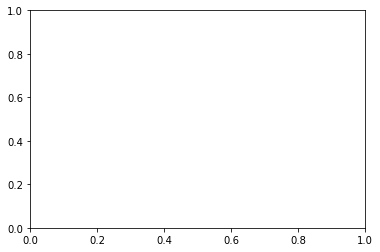

In [76]:
plt.scatter(proj[:, 0], compare[2][0][:, 0])

In [75]:
compare

{2: [array([[ 1.83572912, -0.29418326],
         [ 1.83572912, -0.29418326],
         [ 1.83572912, -0.29418326],
         [ 1.83572912, -0.29418326],
         [ 1.83572912, -0.29418326],
         [ 1.49106567, -0.15913453],
         [ 1.83572912, -0.29418326],
         [ 0.64197882,  0.12306585],
         [ 0.36682574,  0.10032664],
         [ 1.83572912, -0.29418326],
         [ 0.64197882,  0.12306585],
         [ 0.64197882,  0.12306585],
         [-0.41518963,  0.52983008],
         [ 0.64197882,  0.12306585],
         [ 1.83572912, -0.29418326],
         [-0.5633087 ,  0.38981902],
         [ 0.64197882,  0.12306585],
         [ 0.36682574,  0.10032664],
         [ 0.36682574,  0.10032664],
         [-0.61619542,  0.36982124],
         [ 0.36682574,  0.10032664],
         [-0.66537841,  0.47790837],
         [-0.64645154,  0.48828103],
         [-0.60716926,  0.43740889],
         [-0.5633087 ,  0.38981902],
         [-0.60716926,  0.43740889],
         [-0.66537841,  0.47790837]

In [71]:
compare[2]

[array([[ 1.83572912, -0.29418326],
        [ 1.83572912, -0.29418326],
        [ 1.83572912, -0.29418326],
        [ 1.83572912, -0.29418326],
        [ 1.83572912, -0.29418326],
        [ 1.49106567, -0.15913453],
        [ 1.83572912, -0.29418326],
        [ 0.64197882,  0.12306585],
        [ 0.36682574,  0.10032664],
        [ 1.83572912, -0.29418326],
        [ 0.64197882,  0.12306585],
        [ 0.64197882,  0.12306585],
        [-0.41518963,  0.52983008],
        [ 0.64197882,  0.12306585],
        [ 1.83572912, -0.29418326],
        [-0.5633087 ,  0.38981902],
        [ 0.64197882,  0.12306585],
        [ 0.36682574,  0.10032664],
        [ 0.36682574,  0.10032664],
        [-0.61619542,  0.36982124],
        [ 0.36682574,  0.10032664],
        [-0.66537841,  0.47790837],
        [-0.64645154,  0.48828103],
        [-0.60716926,  0.43740889],
        [-0.5633087 ,  0.38981902],
        [-0.60716926,  0.43740889],
        [-0.66537841,  0.47790837],
        [-0.5633087 ,  0.389